In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

import numpy as np
import h5py
import colorsys

from utils.decompose_dict_and_h5_groups import decompose_h5_groups_to_dict
from analysis.utils.extract_from_metadata_file import extract_from_metadata_file
from utils.imaging_utils import load_config
from utils.load_rois_data import load_rois_data

from utils.paint_roi import paint_roi
from analysis.plots import *

from analysis.utils.peristimulus_time_response import calc_pstr


In [2]:
# mouse ID, sessions to examine and all other parameters - CHANGE IT IF NECESSARY
mouse_id = '2604'

sessions_names = [
#     '20220221_neurofeedback',
#     '20220222_neurofeedback',
#     '20220223_neurofeedback',
#     '20220224_neurofeedback',
#     '20220227_neurofeedback',
#     '20220228_neurofeedback',
#     '20220302_neurofeedback',
#     '20220303_neurofeedback',
#     '20220306_neurofeedback',
#     '20220307_neurofeedback'
    '20220320_neurofeedback',
    '20220321_neurofeedback',
    '20220322_neurofeedback',
    '20220323_neurofeedback',
    '20220324_neurofeedback'
]
n_sessions = len(sessions_names)

In [3]:

# data paths
base_path = '/data/Rotem/WideFlow prj'
dataset_path = f'{base_path}/results/sessions_20220320.h5'

# Allen cortex
# cortex_map_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex.h5'
# rois_dict_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex_rois.h5'  # whole cortex
# rois_dict_path = '/data/Rotem/Wide Field/WideFlow/data/cortex_map/allen_2d_cortex_rois.h5'  # cortex left hemisphere

# functional parcellation
cortex_map_path = f'{base_path}/{mouse_id}/functional_parcellation_cortex_map.h5'
rois_dict_path = f'{base_path}/{mouse_id}/functional_parcellation_rois_dict_left_hemi.h5'  # left hemisphere


In [4]:
# load supplementary data
with h5py.File(cortex_map_path, 'r') as f:
#     cortex_mask = np.transpose(f["mask"][()])
#     cortex_map = np.transpose(f["map"][()])
    cortex_mask = f["mask"][()]
    cortex_map = f["map"][()]

rois_dict = load_rois_data(rois_dict_path)
rois_names_code = list(rois_dict.keys())
rois_names = [v['name'] for k, v in rois_dict.items()]
nrois = len(rois_dict)

# load sessions results summary
sessions_data = {}
with h5py.File(dataset_path, 'a') as f:
    decompose_h5_groups_to_dict(f, sessions_data, f'/{mouse_id}/')
    
# exclude sessions that on the sessions_list but not in dataset
for sess_name in sessions_names:
    if sess_name not in list(sessions_data.keys()):
        sessions_names.remove(sess_name)

# load sessions metadata
sessions_metadata = {}
for sess_name in sessions_names:
    sess_metadata_path = f'{base_path}/{mouse_id}/{sess_name}/metadata.txt'
    timestamp, cue, metric_result, threshold, serial_readout = extract_from_metadata_file(sess_metadata_path)
    sessions_metadata[sess_name] = {"timestamp": timestamp, "cue": cue, "metric_result": metric_result, "threshold": threshold, "serial_readout": serial_readout}

# load sessions config
sessions_config = {}
for sess_name in sessions_names:
    sess_config_path = f'{base_path}/{mouse_id}/{sess_name}/session_config.json'
    config = load_config(sess_config_path)
    sessions_config[sess_name] = config


In [5]:
# prepare results
fixed_threshold = sessions_data[sessions_names[0]]['post_session_analysis']['analysis_parameters']['fixed_threshold']
for sess_name in sessions_names:
    if sessions_data[sess_name]['post_session_analysis']['analysis_parameters']['fixed_threshold'] != fixed_threshold:
        print(f"warning: fixed threshold on session {sess_name} is different from session {sessions_names[0]}")
    metric_roi = sessions_config[sess_name]['analysis_pipeline_config']['args']['metric_args'][1][0]
    metric_bool_arr = [True if metric_roi==key else False for key in rois_dict.keys()]
    non_metric_bool_arr = np.invert(metric_bool_arr)
    sessions_metadata[sess_name]['metric_roi'] = metric_roi
    sessions_metadata[sess_name]['metric_bool_arr'] = metric_bool_arr
    sessions_metadata[sess_name]['non_metric_bool_arr'] = non_metric_bool_arr
    
    
# calculate distance between metric roi to all others rois
metric_roi_center = rois_dict[metric_roi]["Centroid"]
rois_proximity = {}
for roi_key, roi_dict in rois_dict.items():
    roi_center = roi_dict["Centroid"]
    dist = np.sqrt((metric_roi_center[0] - roi_center[0])**2 + (metric_roi_center[1] - roi_center[1])**2)
    rois_proximity[roi_key] = dist

pl = list(rois_proximity.values())
pl.sort()
proximity_threshold = pl[5]
print(proximity_threshold)
print(rois_proximity)

25.87562208628387
{'roi_01': 63.22339119336373, 'roi_02': 71.57937104713976, 'roi_03': 87.58032028856941, 'roi_04': 68.4496487038751, 'roi_05': 45.598891875853646, 'roi_06': 48.46390632554305, 'roi_07': 45.77160163016643, 'roi_08': 91.05065268777956, 'roi_09': 116.80892359046035, 'roi_10': 101.67876676919911, 'roi_11': 91.69340333798453, 'roi_12': 68.4598934721646, 'roi_13': 113.7513933562466, 'roi_14': 60.19183611258286, 'roi_15': 87.14634893724337, 'roi_16': 109.29353878665782, 'roi_17': 106.69230595682542, 'roi_18': 75.49259414239415, 'roi_19': 103.05502520087185, 'roi_20': 68.7406517651435, 'roi_21': 115.8039879371744, 'roi_22': 93.39071254005677, 'roi_23': 72.13021782421684, 'roi_24': 49.10043326808828, 'roi_25': 49.17679050632596, 'roi_26': 25.87562208628387, 'roi_27': 36.40723284635294, 'roi_28': 143.63578760791577, 'roi_29': 41.08909883421328, 'roi_30': 95.42770839328222, 'roi_31': 123.12098078191492, 'roi_32': 76.72644655132864, 'roi_33': 103.13020303059123, 'roi_34': 51.07235

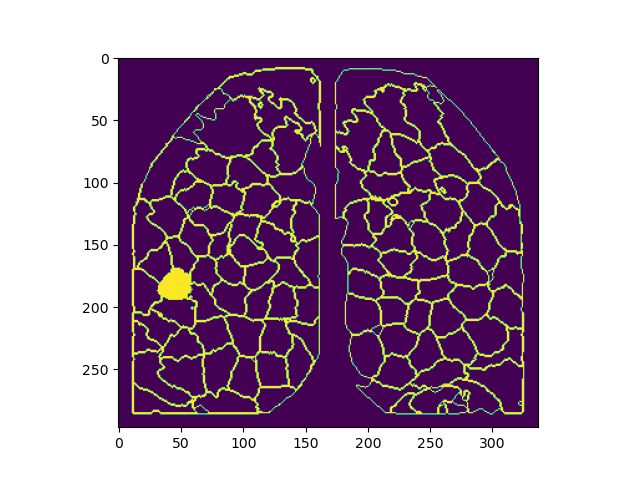

In [6]:
# paint metric roi on the function parcellation map
paint_roi(rois_dict, cortex_map, [metric_roi, ])

/data/Rotem/Wide Field/WideFlow/wideflow/analysis/plots.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.int32(np.linspace(0, t[-1], 10)))


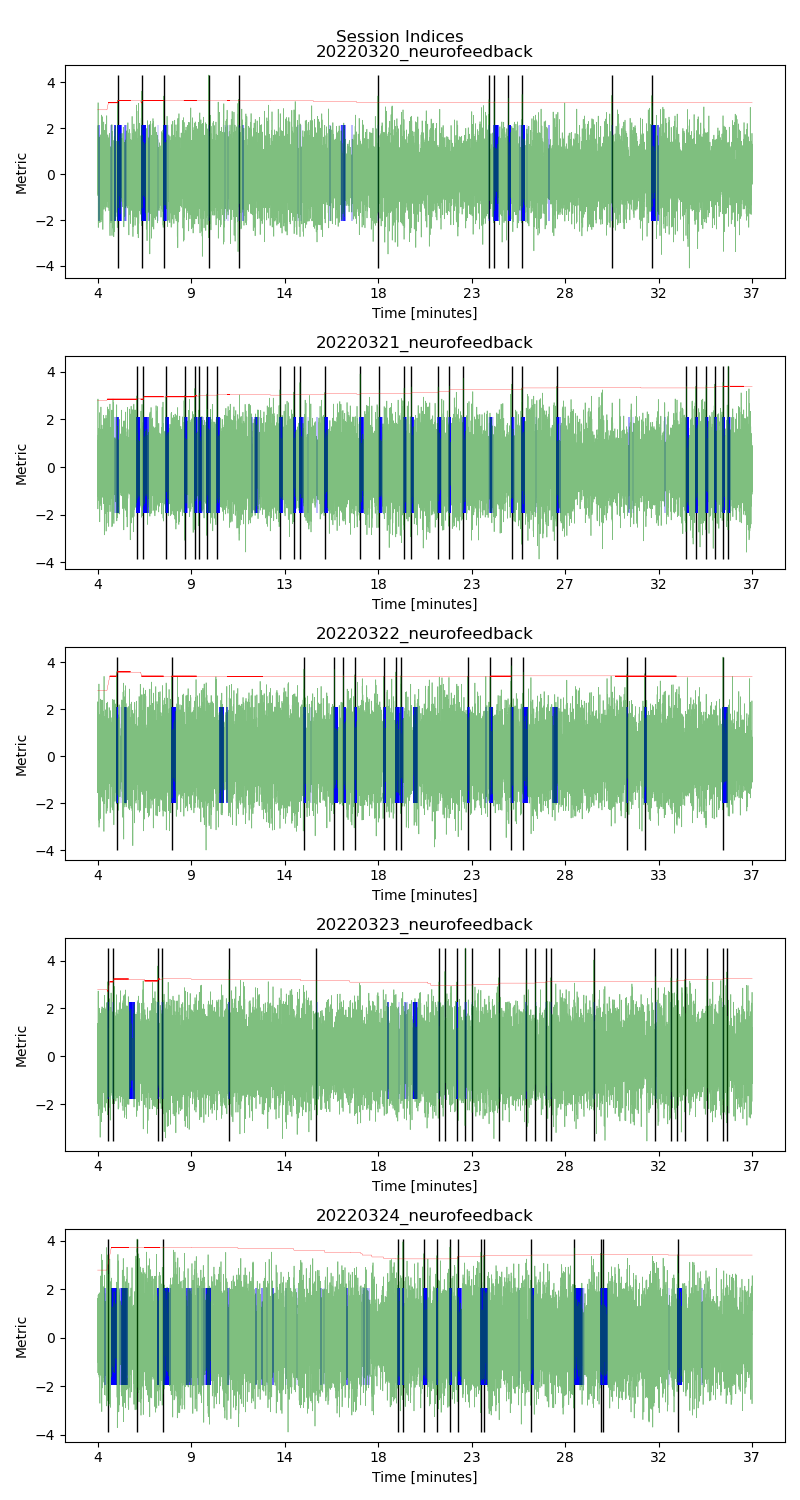

In [7]:
# evaluate learning
# plot sessions indices
f, axes = plt.subplots(len(sessions_names), 1, figsize=(8, n_sessions*3))
if not isinstance(axes, np.ndarray):
    axes = [axes]
for i, sess_name in enumerate(sessions_names):
    dt = np.mean(np.diff(sessions_metadata[sess_name]["timestamp"]))
    plot_session(axes[i], 
                  sessions_metadata[sess_name]["metric_result"], 
                  sessions_metadata[sess_name]["cue"],
                  sessions_metadata[sess_name]["serial_readout"],
                  sessions_metadata[sess_name]["threshold"], 
                  dt/60)
    axes[i].set_title(sess_name)
    
f.suptitle("Session Indices")
plt.tight_layout()


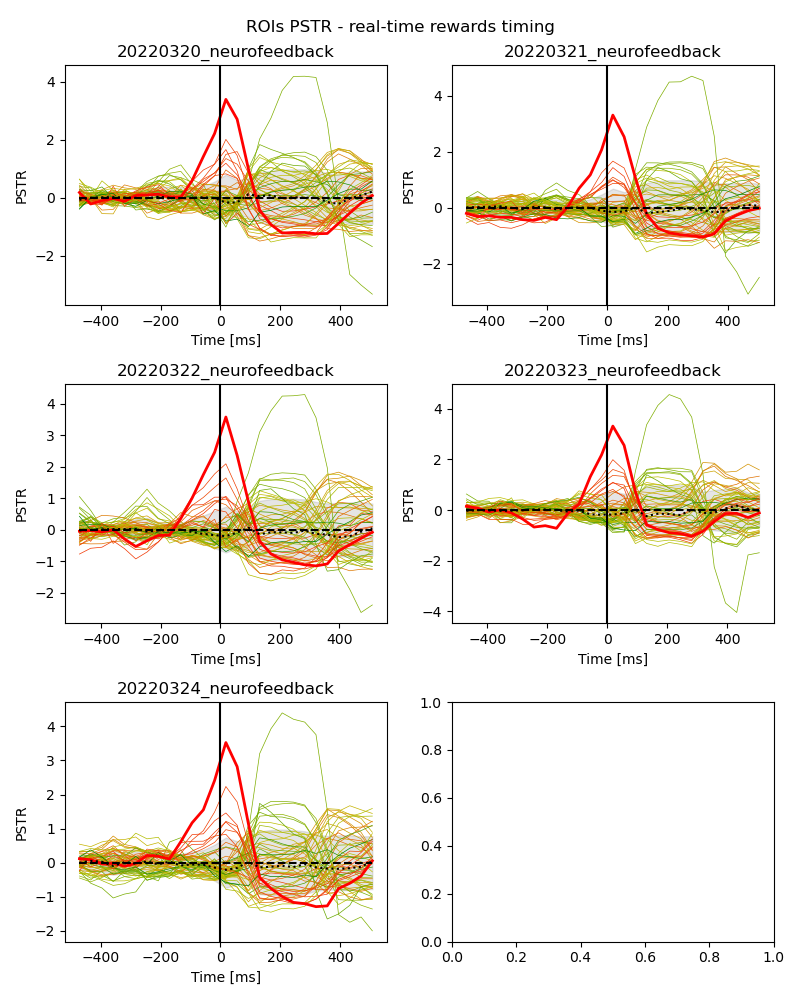

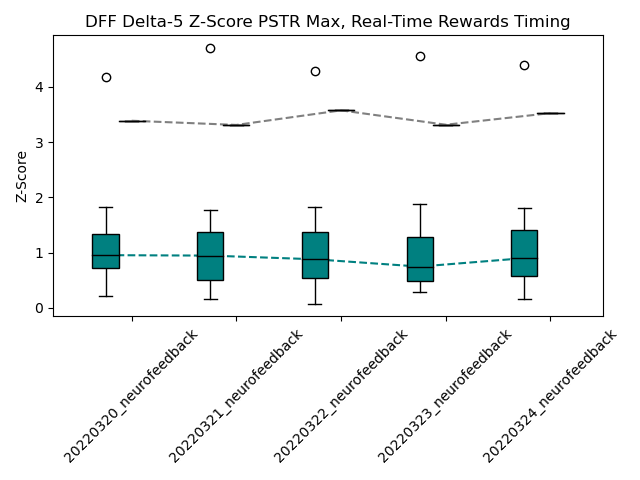

In [8]:
# plot sessions pstr according to real-time rewards timing
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_pstr_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_pstr_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_pstr(axes[int(np.floor(i/2)) ,i%2], rois_pstr_dict, dt, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
    
f.suptitle("ROIs PSTR - real-time rewards timing") 
plt.tight_layout()



# plot sessions pstr maximum value box-plot according to real time rewards timing
pstr_zscore_max_nm, pstr_zscore_max_m = [], []
for i, sess_name in enumerate(sessions_names):
    pstr_zscore_max_m.append([])
    pstr_zscore_max_nm.append([])
    for j, roi_key in enumerate(rois_dict.keys()):
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            pstr_zscore_max_m[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr'][j]))
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                pstr_zscore_max_nm[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr'][j]))
        
pstr_zscore_max_m = np.transpose(np.array(pstr_zscore_max_m))
pstr_zscore_max_nm = np.transpose(np.array(pstr_zscore_max_nm))


f, ax = plt.subplots()        
plot_box_plot(ax, pstr_zscore_max_nm, pstr_zscore_max_m, 
              set_title="DFF Delta-5 Z-Score PSTR Max, Real-Time Rewards Timing",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel = 'Z-Score')
plt.tight_layout()

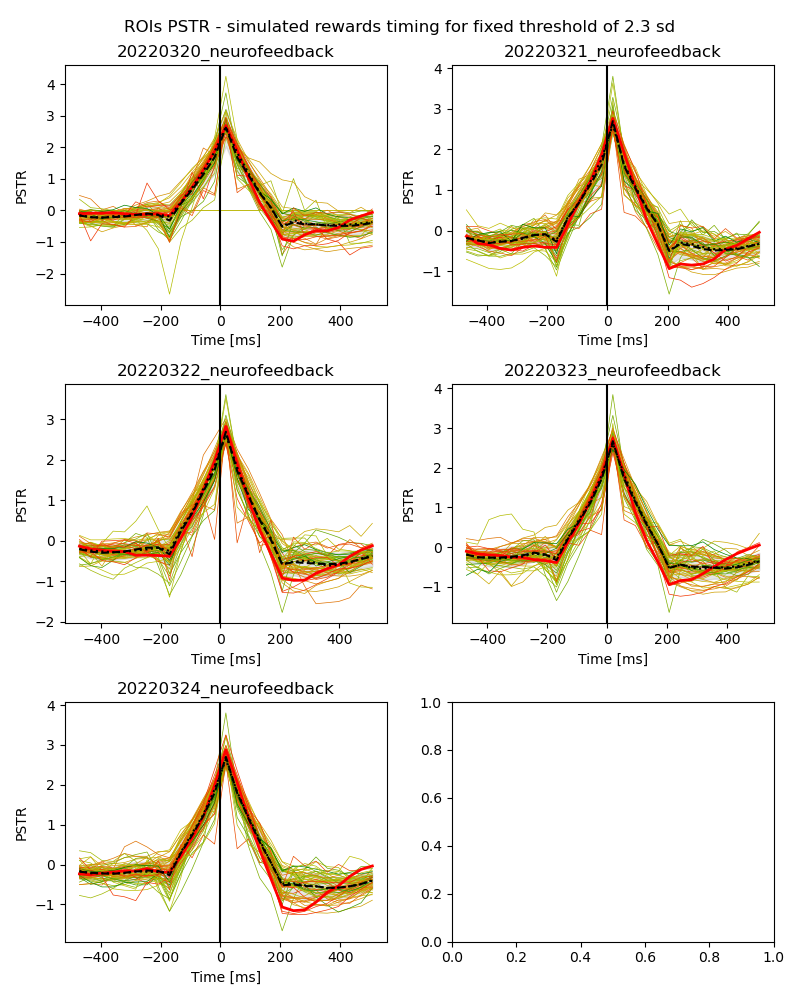

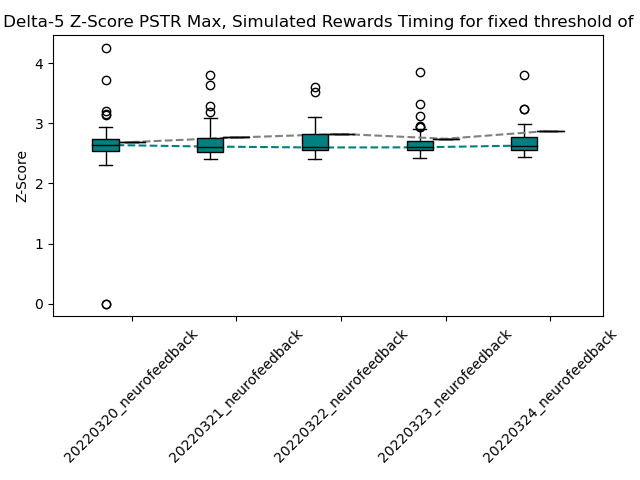

In [9]:
# plot sessions pstr according to simulated reward
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_pstr_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_pstr_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward_fix_th'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_pstr(axes[int(np.floor(i/2)), i%2], rois_pstr_dict, dt, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
         
f.suptitle(f"ROIs PSTR - simulated rewards timing for fixed threshold of {fixed_threshold} sd") 
plt.tight_layout()



# plot sessions pstr maximum value box-plot according to simulated rewards timing, for a fixed threshold
pstr_zscore_max_nm, pstr_zscore_max_m = [], []
for i, sess_name in enumerate(sessions_names):
    pstr_zscore_max_m.append([])
    pstr_zscore_max_nm.append([])
    for j, roi_key in enumerate(rois_dict.keys()):
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            pstr_zscore_max_m[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward_fix_th'][j]))
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                pstr_zscore_max_nm[i].append(np.max(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_pstr_sim_reward_fix_th'][j]))
        
pstr_zscore_max_m = np.transpose(np.array(pstr_zscore_max_m))
pstr_zscore_max_nm = np.transpose(np.array(pstr_zscore_max_nm))


f, ax = plt.subplots()        
plot_box_plot(ax, pstr_zscore_max_nm, pstr_zscore_max_m, 
              set_title=f"DFF Delta-5 Z-Score PSTR Max, Simulated Rewards Timing for fixed threshold of {fixed_threshold} sd",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel = 'Z-Score')
plt.tight_layout()

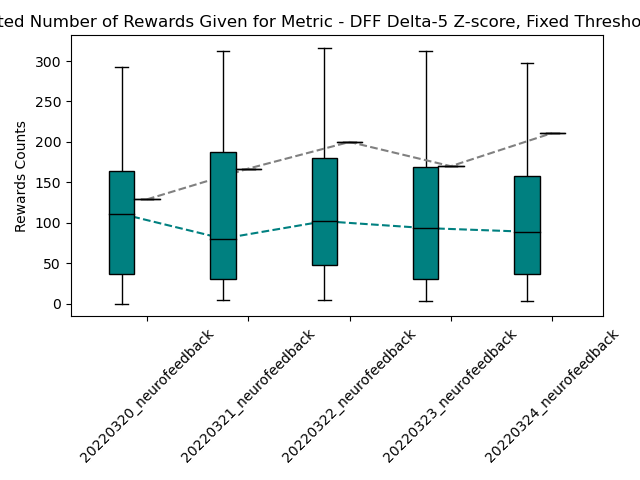

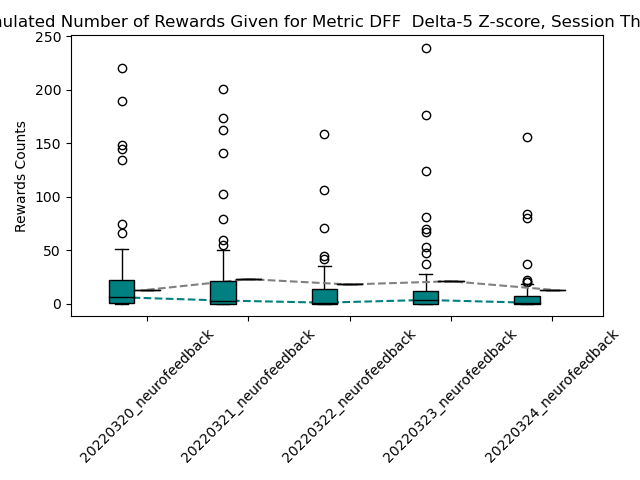

In [10]:
# plot sessions number of rewards box-plot according to simulated rewards timing, for a fixed threshold
num_of_rewards_nm, num_of_rewards_m = [], []
for i, sess_name in enumerate(sessions_names):
    num_of_rewards_m.append([])
    num_of_rewards_nm.append([])
    for roi_key, roi_val in sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_sim_reward_timing_fix_th'].items():
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            num_of_rewards_m[i].append(len(roi_val))
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                num_of_rewards_nm[i].append(len(roi_val))
        
num_of_rewards_m = np.transpose(np.array(num_of_rewards_m))
num_of_rewards_nm = np.transpose(np.array(num_of_rewards_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, num_of_rewards_nm, num_of_rewards_m, 
              set_title=f"Simulated Number of Rewards Given for Metric - DFF Delta-5 Z-score, Fixed Threshold of {fixed_threshold} sd",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='Rewards Counts')
plt.tight_layout()



# plot sessions number of rewards box-plot according to simulated rewards timing, for session threshold
num_of_rewards_nm, num_of_rewards_m = [], []
for i, sess_name in enumerate(sessions_names):
    num_of_rewards_m.append([])
    num_of_rewards_nm.append([])
    for roi_key, roi_val in sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_sim_reward_timing_session_th'].items():
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            num_of_rewards_m[i].append(len(roi_val))
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                num_of_rewards_nm[i].append(len(roi_val))
        
num_of_rewards_m = np.transpose(np.array(num_of_rewards_m))
num_of_rewards_nm = np.transpose(np.array(num_of_rewards_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, num_of_rewards_nm, num_of_rewards_m, 
              set_title="Simulated Number of Rewards Given for Metric DFF  Delta-5 Z-score, Session Threshold",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='Rewards Counts')
plt.tight_layout()

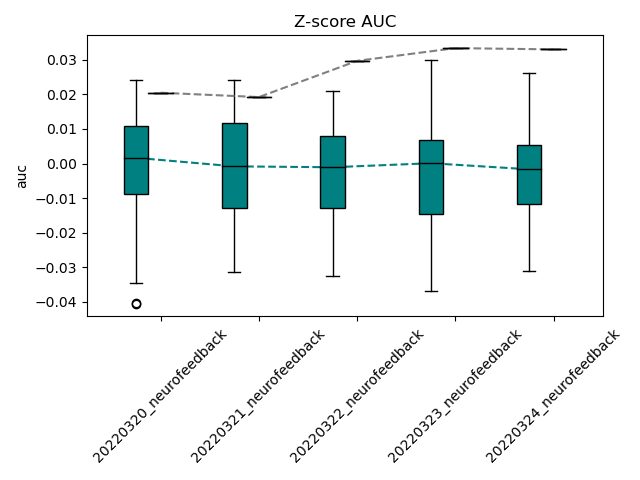

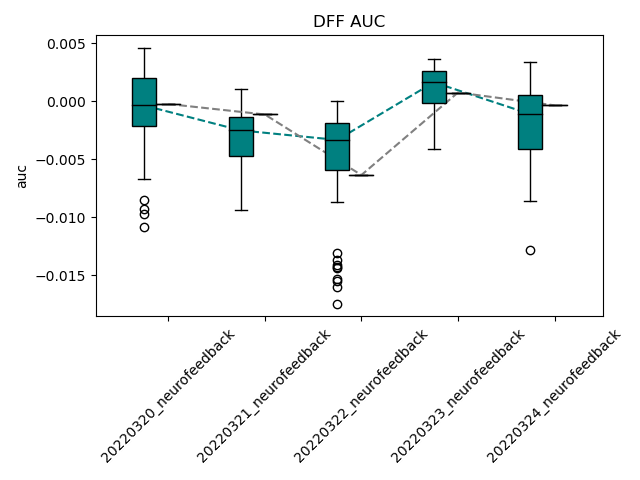

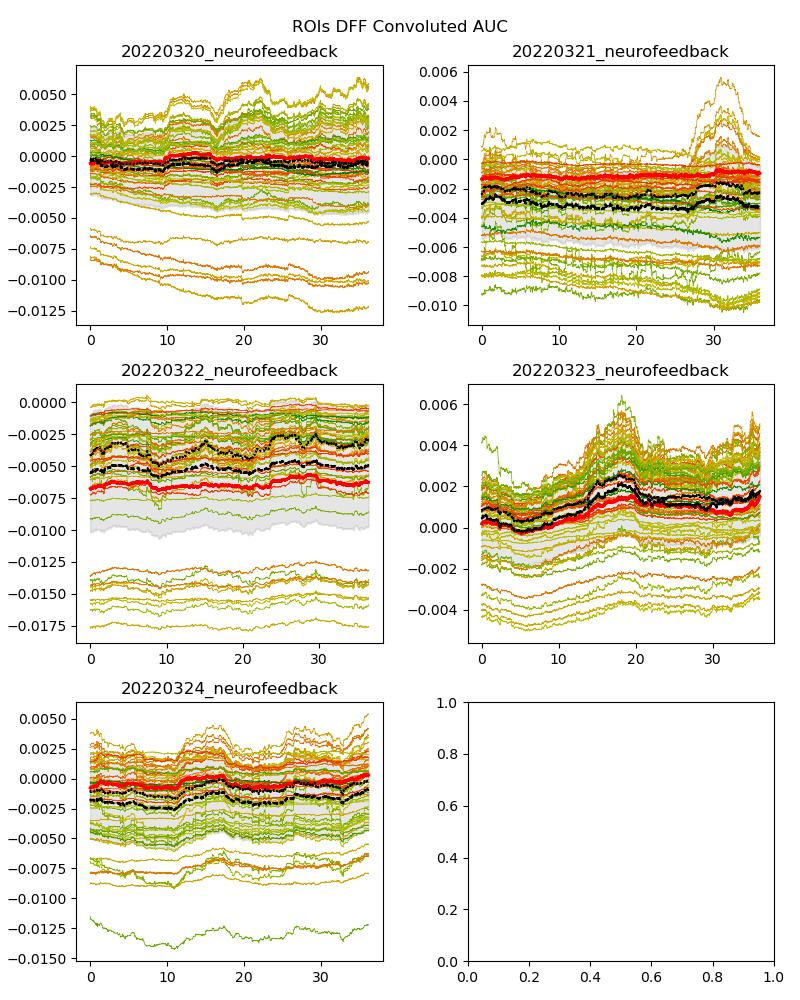

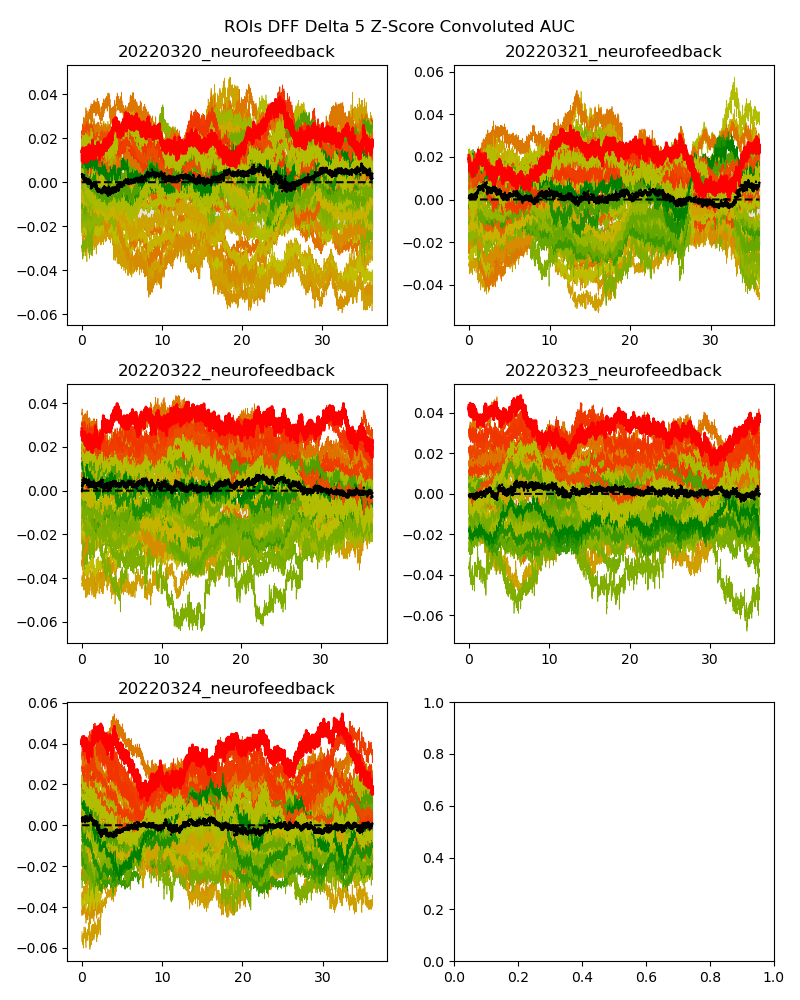

In [11]:
# plot sessions box-plot according to Z-score AUC
zscore_auc_nm, zscore_auc_m = [], []
for i, sess_name in enumerate(sessions_names):
    zscore_auc_m.append([])
    zscore_auc_nm.append([])
    for j, roi_key in enumerate(rois_dict.keys()):
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            zscore_auc_m[i].append(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_auc'][j])
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                zscore_auc_nm[i].append(sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_auc'][j])
        
zscore_auc_m = np.transpose(np.array(zscore_auc_m))
zscore_auc_nm = np.transpose(np.array(zscore_auc_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, zscore_auc_nm, zscore_auc_m, 
              set_title="Z-score AUC",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='auc')
plt.tight_layout()


# plot sessions box-plot according to dff AUC
auc_nm, auc_m = [], []
for i, sess_name in enumerate(sessions_names):
    auc_m.append([])
    auc_nm.append([])
    for j, roi_key in enumerate(rois_dict.keys()):
        if roi_key == sessions_metadata[sess_name]['metric_roi']:
            auc_m[i].append(sessions_data[sess_name]['post_session_analysis']['dff']['traces_auc'][j])
        else:
            if rois_proximity[roi_key] > proximity_threshold:
                auc_nm[i].append(sessions_data[sess_name]['post_session_analysis']['dff']['traces_auc'][j])
        
auc_m = np.transpose(np.array(auc_m))
auc_nm = np.transpose(np.array(auc_nm))

f, ax = plt.subplots()        
plot_box_plot(ax, auc_nm, auc_m, 
              set_title="DFF AUC",
              set_xticklabels={'labels':sessions_names, 'rotation':45},
              set_ylabel='auc')
plt.tight_layout()


# plot session dff convoluted traces area under the curve 
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_conv_auc_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_conv_auc_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff']['traces_moving_avg_auc'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_traces(axes[int(np.floor(i/2)) ,i%2], rois_conv_auc_dict, dt/60*2, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
    
f.suptitle("ROIs DFF Convoluted AUC")
plt.tight_layout()



# plot session dff diff 5 convoluted Z-score area under the curve 
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_conv_auc_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_conv_auc_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_moving_avg_auc'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_traces(axes[int(np.floor(i/2)) ,i%2], rois_conv_auc_dict, dt/60*2, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
    
f.suptitle("ROIs DFF Delta 5 Z-Score Convoluted AUC")
plt.tight_layout()


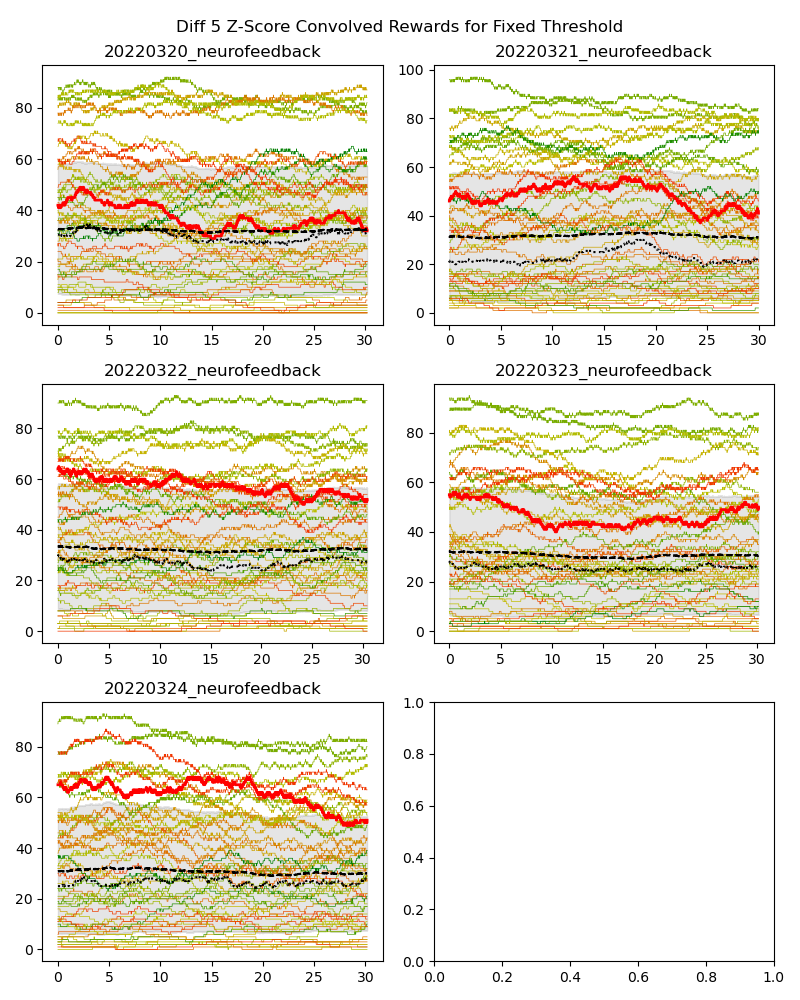

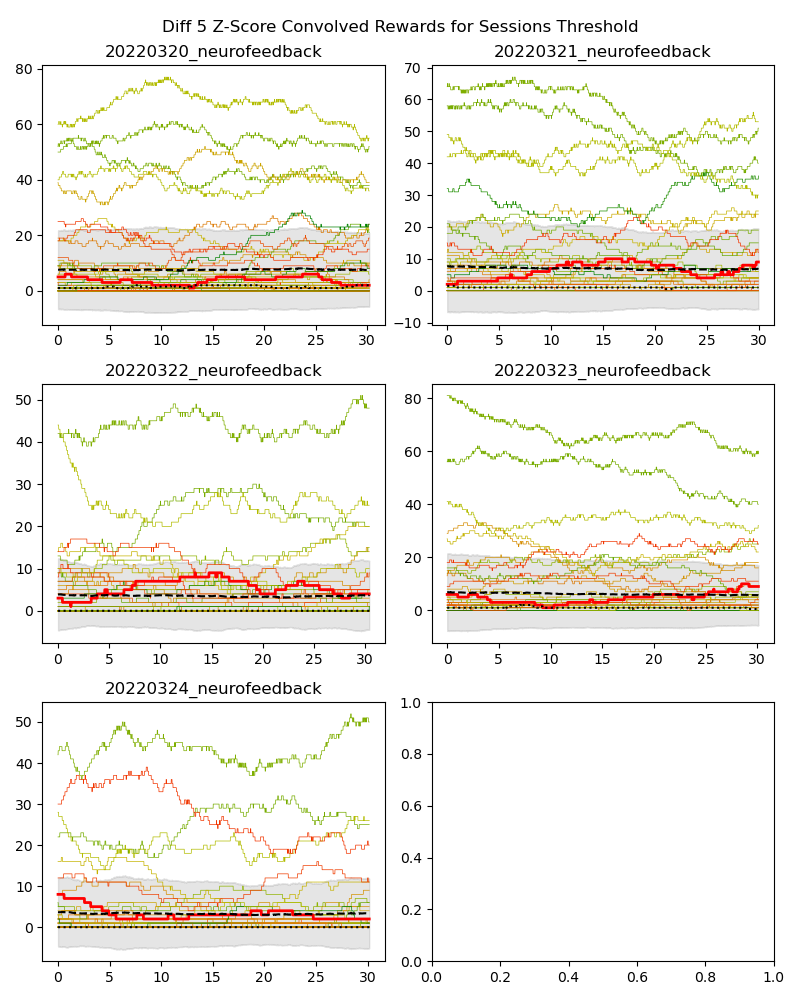

In [12]:
# plot sessions convoluted rewards deltas for fixed threshold, diff 5 Z-score metric
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_conv_rewards_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_conv_rewards_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_convoluted_peaks_kernel_10k_fix_th'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_traces(axes[int(np.floor(i/2)) ,i%2], rois_conv_rewards_dict, dt/60*2, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
    
f.suptitle("Diff 5 Z-Score Convolved Rewards for Fixed Threshold")
plt.tight_layout()


# plot sessions convoluted rewards deltas for sessions threshold, diff 5 Z-score metric
f, axes = plt.subplots(int(np.ceil(n_sessions/2)), 2, figsize=(8, n_sessions*2))
if not isinstance(axes, np.ndarray):
    axes = [axes]
if axes.ndim == 1:
    axes = np.expand_dims(axes, 0)
for i, sess_name in enumerate(sessions_names):
    rois_conv_rewards_dict = {}
    for j, roi_key in enumerate(rois_dict.keys()):
        rois_conv_rewards_dict[roi_key] = sessions_data[sess_name]['post_session_analysis']['dff_delta5']['zscore_convoluted_peaks_kernel_10k_session_th'][j]
    
    dt = np.mean(np.diff(sessions_metadata[sess_name]['timestamp']))
    plot_traces(axes[int(np.floor(i/2)) ,i%2], rois_conv_rewards_dict, dt/60*2, metric_roi, rois_proximity)
    axes[int(np.floor(i/2)), i%2].set_title(sess_name)
    
f.suptitle("Diff 5 Z-Score Convolved Rewards for Sessions Threshold")
plt.tight_layout()